## Checking the backward phase

In [1]:
import numpy as np
import sempler
import sempler.generators
import sempler.utils
import matplotlib.pyplot as plt
import pandas as pd

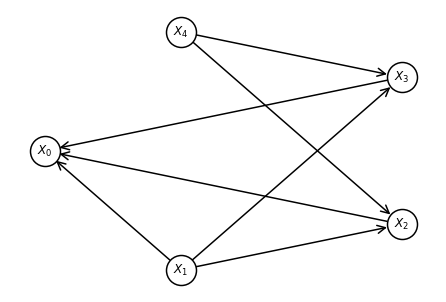

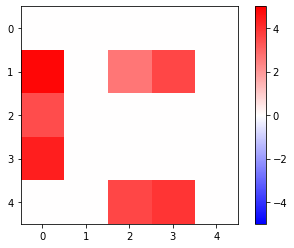

In [2]:
np.random.seed(1)
true_A = np.array([[0,0,1,0,0],
                 [0,0,1,0,0],
                 [0,0,0,1,1],
                 [0,0,0,0,1],
                 [0,0,0,0,0]])
p = len(true_A)
p = 5
true_A = sempler.generators.dag_avg_deg(p, 2.1)

sempler.utils.plot_graph(true_A)
W = true_A * np.random.uniform(2,5,size=true_A.shape)

scm = sempler.LGANM(W, (2,3), (1,2))
plt.imshow(W, vmin=-5, vmax=5, cmap='bwr')
plt.colorbar()

In [3]:
#np.random.seed(12)
n = 1000
XX = [scm.sample(n)]

interventions = [{0: (10, 0)}
                 ,{1: (10, 0)}
                 #,{2: (0, 10)}
                 #,{3: (0, 10)}
                 ,{4: (10, 0)}
                ]

for i in interventions:
    XX.append(scm.sample(n, shift_interventions=i))

print("Data from %d environments" % len(XX))

sample_covariances = np.array([np.cov(env, rowvar=False, ddof=0) for env in XX])
n_obs = np.array([len(env) for env in XX])

Data from 4 environments


### Write the data into a CSV

In [4]:
flattened = []
for e,X in enumerate(XX):
    flagged = np.hstack([np.ones((len(X),1)) * e, X])
    flattened.append(flagged)
flattened = np.vstack(flattened)
flattened

array([[  0.        , 191.74336512,   3.07118338,  20.02729497,
         24.00564792,   2.48349815],
       [  0.        , 160.22566738,   1.26463081,  17.2572267 ,
         20.6157823 ,   3.31226054],
       [  0.        , 177.62145868,   2.72869241,  16.60217647,
         23.50467233,   2.01613708],
       ...,
       [  3.        , 416.46613275,   1.90650338,  50.03642423,
         52.79745852,  11.30126988],
       [  3.        , 481.23033432,   2.56481385,  54.41822377,
         63.49388984,  12.53389892],
       [  3.        , 405.57439575,   1.00961449,  47.30402025,
         53.10457197,  12.05277798]])

In [5]:
path = 'data/test_data.csv'
df = pd.DataFrame(flattened)
df.to_csv(path, header=False, index=False)

In [6]:
pd.read_csv(path, header=None)

,0,1,2,3,4,5
0,0.0,191.743365,3.071183,20.027295,24.005648,2.483498
1,0.0,160.225667,1.264631,17.257227,20.615782,3.312261
2,0.0,177.621459,2.728692,16.602176,23.504672,2.016137
3,0.0,204.925041,2.292719,21.153197,26.790116,3.581900
4,0.0,234.011600,3.322295,26.130822,28.188045,3.502306
...,...,...,...,...,...,...
3995,3.0,480.616249,2.065011,55.416389,62.365324,12.934588
3996,3.0,344.850732,-1.059104,41.895865,46.675506,11.666022
3997,3.0,416.466133,1.906503,50.036424,52.797459,11.301270
3998,3.0,481.230334,2.564814,54.418224,63.493890,12.533899


### Test the GaussianData class

In [7]:
from causalicp import GaussianData

In [8]:
scm.sample(population=True).covariance

array([[2.99445325e+03, 4.91329118e+01, 3.14342323e+02, 3.79230341e+02,
        4.92649972e+01],
       [4.91329118e+01, 1.63783648e+00, 4.41076943e+00, 5.89677717e+00,
        0.00000000e+00],
       [3.14342323e+02, 4.41076943e+00, 3.45411463e+01, 3.94517870e+01,
        5.95706570e+00],
       [3.79230341e+02, 5.89677717e+00, 3.94517870e+01, 4.87195031e+01,
        6.51997407e+00],
       [4.92649972e+01, 0.00000000e+00, 5.95706570e+00, 6.51997407e+00,
        1.64774940e+00]])

In [9]:
data = GaussianData(XX)
scm.W, scm.means

(array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [4.86960697, 0.        , 2.69304627, 3.60034547, 0.        ],
        [3.47917878, 0.        , 0.        , 0.        , 0.        ],
        [4.37721076, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 3.61527408, 3.95689665, 0.        ]]),
 array([2.35393909, 2.76323305, 2.35653172, 2.75278835, 2.88134183]))

#### Not the same to center data and to add intercept column

In [10]:
y = 2
S = {1,4}

In [11]:
data = GaussianData(XX, method = 'raw')

In [12]:
%%time
data.regress_pooled(y, S)

CPU times: user 1.56 ms, sys: 87 µs, total: 1.65 ms
Wall time: 1.02 ms


(array([0.        , 2.69358182, 0.        , 0.        , 3.61161357]),
 2.380015094909832)

In [13]:
data = GaussianData(XX, method = 'scatter')

In [14]:
%%time
data.regress_pooled(y, S)

CPU times: user 1.73 ms, sys: 95 µs, total: 1.83 ms
Wall time: 1.23 ms


(array([0.        , 2.69358182, 0.        , 0.        , 3.61161357]),
 2.380015094909858)

### Test ICP

In [15]:
import causalicp as icp

In [16]:
%%time
target = 2
result = icp.fit(XX, target, alpha=0.001, verbose=True)

Tested sets and their p-values
  set() rejected - (p=0.0000)
  {0} rejected - (p=0.0000)
  {1} rejected - (p=0.0000)
  {3} rejected - (p=0.0000)
  {4} rejected - (p=0.0000)
  {0, 1} rejected - (p=0.0000)
  {0, 3} rejected - (p=0.0000)
  {0, 4} rejected - (p=0.0000)
  {1, 3} accepted - (p=0.0028)
  {1, 4} accepted - (p=1.6117)
  {3, 4} accepted - (p=0.0079)
  {0, 1, 3} rejected - (p=0.0000)
  {0, 1, 4} rejected - (p=0.0000)
  {0, 3, 4} rejected - (p=0.0000)
  {1, 3, 4} accepted - (p=1.6102)
  {0, 1, 3, 4} rejected - (p=0.0000)

Estimated parental set: set()

CPU times: user 174 ms, sys: 16.1 ms, total: 190 ms
Wall time: 99.9 ms


In [17]:
for S in result.accepted:
    adapted = []
    for s in S:
        if s > target:
            adapted.append(s)
        else:
            adapted.append(s+1)
    print(adapted)

[2, 3]
[2, 4]
[3, 4]
[2, 3, 4]


In [18]:
result.estimate

set()